In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
DATA_DIR="/content/drive/MyDrive/Dataset"

In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/Dataset"

# Function to explore the dataset
def explore_dataset(folder_path):
    classes = []
    num_images = []
    for folder in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, folder)):
            classes.append(folder)
            num_images.append(len(os.listdir(os.path.join(folder_path, folder))))
    return classes, num_images

# Explore the dataset
classes, num_images = explore_dataset(DATA_DIR)

# Print the classes and number of images in each class
for cls, num in zip(classes, num_images):
    print(f"Class: {cls}, Number of images: {num}")


Class: Non_Demented, Number of images: 1471
Class: Very_Mild_Demented, Number of images: 1110
Class: Mild_Demented, Number of images: 385
Class: Moderate_Demented, Number of images: 44


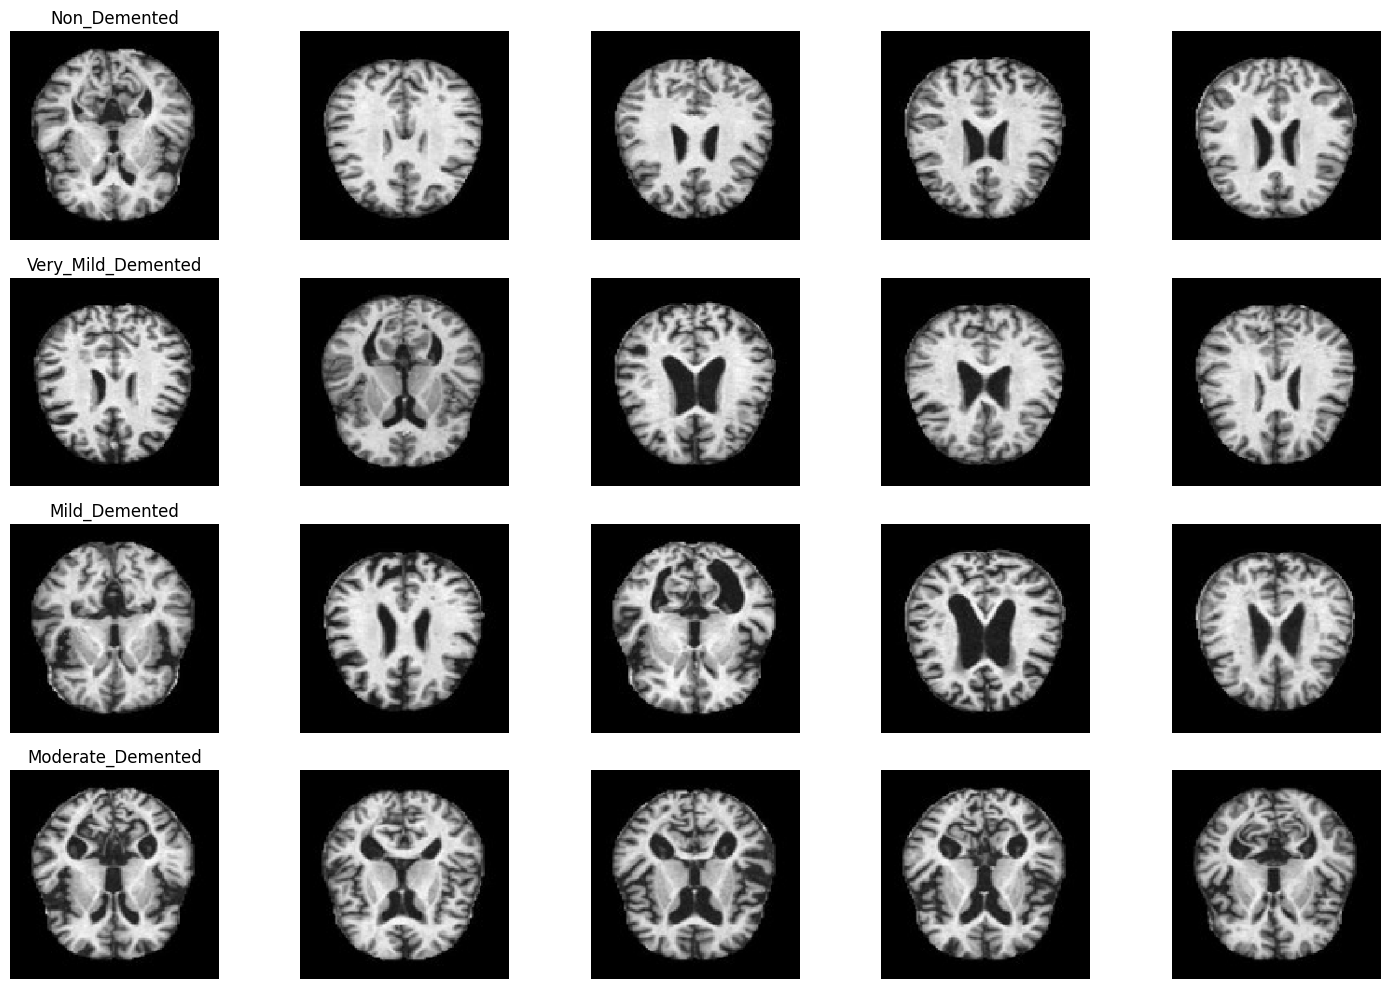

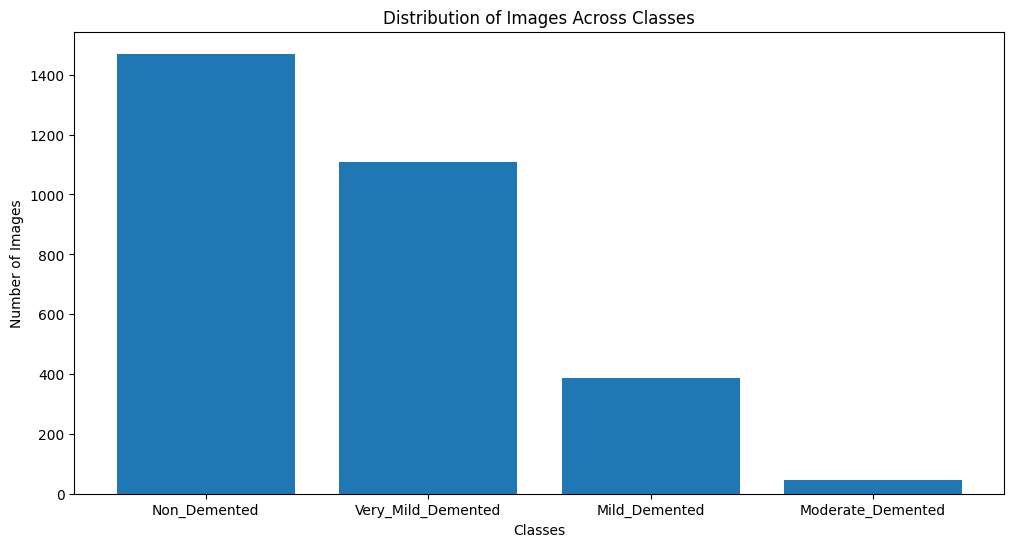

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

DATA_DIR = "/content/drive/MyDrive/Dataset"
NUM_SAMPLES = 5  # Number of sample images to visualize per class

# Function to plot sample images from each class
def plot_sample_images(folder_path, classes, num_samples):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        image_files = os.listdir(class_path)
        sample_images = random.sample(image_files, min(num_samples, len(image_files)))
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(class_path, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis("off")
            if j == 0:
                plt.title(cls)
    plt.tight_layout()
    plt.show()

# Function to plot histogram of image distribution across classes
def plot_class_distribution(classes, num_images):
    plt.figure(figsize=(12, 6))
    plt.bar(classes, num_images)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Images Across Classes")
    plt.show()

# Explore the dataset
classes, num_images = explore_dataset(DATA_DIR)

# Plot sample images from each class
plot_sample_images(DATA_DIR, classes, NUM_SAMPLES)

# Plot histogram of image distribution
plot_class_distribution(classes, num_images)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)


# Load images and labels
X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])



# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), epochs=10, validation_data=(X_test, y_test))



# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


# Function to calculate accuracy, precision, recall, F1 score, and NPV
def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    return accuracy, precision, recall, f1, npv


# Predict labels for X_train and X_test
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

# Calculate metrics for X_train and X_test
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1 Score:", train_f1)
print("Train Confusion Matrix:\n", train_confusion_matrix)

print("\nTest Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test Confusion Matrix:\n", test_confusion_matrix)





Epoch 1/10
76/76 [==============================] - 380s 5s/step - loss: 1.0859 - accuracy: 0.4664 - val_loss: 1.0594 - val_accuracy: 0.5100
Epoch 2/10
76/76 [==============================] - 374s 5s/step - loss: 1.0526 - accuracy: 0.4722 - val_loss: 1.0894 - val_accuracy: 0.3455
Epoch 3/10
76/76 [==============================] - 362s 5s/step - loss: 1.0515 - accuracy: 0.4784 - val_loss: 1.0481 - val_accuracy: 0.5100
Epoch 4/10
76/76 [==============================] - 365s 5s/step - loss: 1.0518 - accuracy: 0.4722 - val_loss: 1.0445 - val_accuracy: 0.5100
Epoch 5/10
76/76 [==============================] - 362s 5s/step - loss: 1.0198 - accuracy: 0.4958 - val_loss: 0.9674 - val_accuracy: 0.5249
Epoch 6/10
76/76 [==============================] - 358s 5s/step - loss: 0.9710 - accuracy: 0.5361 - val_loss: 1.0685 - val_accuracy: 0.4767
Epoch 7/10
76/76 [==============================] - 360s 5s/step - loss: 0.9802 - accuracy: 0.5370 - val_loss: 0.9518 - val_accuracy: 0.5116
Epoch 8/10
76

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)


# Load images and labels
X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Flatten the 3D images into 2D arrays for Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_flat, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_flat)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)



from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Function to calculate accuracy, precision, recall, F1 score, and NPV
def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate confusion matrix values directly
    tn, fp, fn, tp = 0, 0, 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 0 and y_pred[i] == 0:
            tn += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            fp += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            fn += 1
        elif y_true[i] == 1 and y_pred[i] == 1:
            tp += 1

    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    return accuracy, precision, recall, f1, npv

# Predict labels for X_train and X_test
y_train_pred = rf_classifier.predict(X_train_flat)
y_test_pred = rf_classifier.predict(X_test_flat)

# Calculate metrics for X_train and X_test
train_accuracy, train_precision, train_recall, train_f1, train_npv = calculate_metrics(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1, test_npv = calculate_metrics(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1 Score:", train_f1)
print("Train NPV:", train_npv)

print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test NPV:", test_npv)





Random Forest Accuracy: 0.8588039867109635
Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Train NPV: 1.0

Test Accuracy: 0.8588039867109635
Test Precision: 0.8681692940671042
Test Recall: 0.8588039867109635
Test F1 Score: 0.852581271806275
Test NPV: 1.0


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Flatten the 3D images into 2D arrays for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create an MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Train the classifier
mlp_classifier.fit(X_train_flat, y_train)

# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test_flat)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("MLP Accuracy:", accuracy)


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to calculate accuracy, precision, recall, F1 score, and NPV
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    tn, fp, fn, tp = 0, 0, 0, 0  # Setting these to 0 as they are not used
    npv = 0  # Setting this to 0 as it's not used
    return accuracy, precision, recall, f1, npv

# Predict labels for X_train and X_test
y_train_pred = mlp_classifier.predict(X_train_flat)
y_test_pred = mlp_classifier.predict(X_test_flat)

# Calculate metrics for X_train and X_test
train_accuracy, train_precision, train_recall, train_f1, train_npv = calculate_metrics(y_train, y_train_pred)
test_accuracy, test_precision, test_recall, test_f1, test_npv = calculate_metrics(y_test, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1 Score:", train_f1)
print("Train NPV:", train_npv)

print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test NPV:", test_npv)




MLP Accuracy: 0.7093023255813954
Train Accuracy: 0.8006644518272426
Train Precision: 0.8540156741896665
Train Recall: 0.8006644518272426
Train F1 Score: 0.7715914866428891
Train NPV: 0

Test Accuracy: 0.7093023255813954
Test Precision: 0.7875682196989028
Test Recall: 0.7093023255813954
Test F1 Score: 0.6769244190424819
Test NPV: 0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)


# Load images and labels
X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to fit the LSTM input shape
X_train_rnn = X_train.reshape(-1, 1, X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_rnn = X_test.reshape(-1, 1, X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

# Define and compile the model
model = Sequential([
    LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_rnn, y_test)
print("RNN Accuracy:", accuracy)
# Predict probabilities for X_train_rnn and X_test_rnn
y_train_prob = model.predict(X_train_rnn)
y_test_prob = model.predict(X_test_rnn)

# Get predicted class indices
y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate metrics for X_train_rnn and X_test_rnn
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Train Accuracy:", train_accuracy)
print("Train Precision:", train_precision)
print("Train Recall:", train_recall)
print("Train F1 Score:", train_f1)

print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)

Epoch 1/10
76/76 [==============================] - 166s 2s/step - loss: 13.4465 - accuracy: 0.4419 - val_loss: 1.9122 - val_accuracy: 0.4518
Epoch 2/10
76/76 [==============================] - 162s 2s/step - loss: 1.8257 - accuracy: 0.5386 - val_loss: 4.2808 - val_accuracy: 0.3455
Epoch 3/10
76/76 [==============================] - 160s 2s/step - loss: 1.3994 - accuracy: 0.6117 - val_loss: 2.3293 - val_accuracy: 0.5233
Epoch 4/10
76/76 [==============================] - 163s 2s/step - loss: 0.8920 - accuracy: 0.6665 - val_loss: 1.4215 - val_accuracy: 0.5797
Epoch 5/10
76/76 [==============================] - 155s 2s/step - loss: 0.9465 - accuracy: 0.6582 - val_loss: 1.4520 - val_accuracy: 0.6628
Epoch 6/10
76/76 [==============================] - 155s 2s/step - loss: 0.9355 - accuracy: 0.6931 - val_loss: 0.5140 - val_accuracy: 0.8090
Epoch 7/10
76/76 [==============================] - 161s 2s/step - loss: 0.7382 - accuracy: 0.7189 - val_loss: 0.9942 - val_accuracy: 0.6196
Epoch 8/10
7

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neural_network import MLPClassifier


DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the input data to 2D

# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, random_state=42)
mlp.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the input data to 2D

# Predict with Random Forest
rf_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the input data to 2D

# Predict with MLP
mlp_pred = mlp.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the input data to 2D

# Combine predictions using a simple averaging method
#combined_pred = (rf_pred + mlp_pred) / 2

# Evaluate the combined model
from scipy.stats import mode

# Combine predictions using mode
combined_pred = mode([rf_pred, mlp_pred])[0]

# Flatten the combined prediction array
combined_pred = combined_pred.ravel()

# Evaluate the combined model
accuracy = accuracy_score(y_test, combined_pred)
print("Combined Model Accuracy:", accuracy)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the combined model
accuracy_combined = accuracy_score(y_test, combined_pred)
precision_combined = precision_score(y_test, combined_pred, average='weighted')
recall_combined = recall_score(y_test, combined_pred, average='weighted')
f1_combined = f1_score(y_test, combined_pred, average='weighted')

print("Combined Model Accuracy:", accuracy_combined)
print("Combined Model Precision:", precision_combined)
print("Combined Model Recall:", recall_combined)
print("Combined Model F1 Score:", f1_combined)



Combined Model Accuracy: 0.8704318936877077
Combined Model Accuracy: 0.8704318936877077
Combined Model Precision: 0.8786325494664872
Combined Model Recall: 0.8704318936877077
Combined Model F1 Score: 0.8652391571474082


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import image

DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)

X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train and X_test to 2D arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)

svm = SVC()
svm.fit(X_train_flat, y_train)

mlp = MLPClassifier()
mlp.fit(X_train_flat, y_train)

# Get predictions from base models on the test set
rf_pred_test = rf.predict(X_test_flat)
svm_pred_test = svm.predict(X_test_flat)
mlp_pred_test = mlp.predict(X_test_flat)

# One-hot encode the predictions for the meta-model
enc = OneHotEncoder(sparse=False)
rf_pred_enc_test = enc.fit_transform(rf_pred_test.reshape(-1, 1))
svm_pred_enc_test = enc.transform(svm_pred_test.reshape(-1, 1))
mlp_pred_enc_test = enc.transform(mlp_pred_test.reshape(-1, 1))

# Concatenate the predictions
X_test_stacked = np.concatenate((rf_pred_enc_test, svm_pred_enc_test, mlp_pred_enc_test), axis=1)

# Train a Random Forest model on the concatenated predictions
rf_stacked = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stacked.fit(X_test_stacked, y_test)

# Evaluate the stacked model
rf_pred_test_stacked = rf_stacked.predict(X_test_stacked)
accuracy_stacked = np.mean(rf_pred_test_stacked == y_test)
print("Stacked Model Accuracy:", accuracy_stacked)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Stacked Model Accuracy: 0.9186046511627907


In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing import image

DATA_DIR = "/content/drive/MyDrive/Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to load images from a folder
def load_images_from_folder(folder_path, IMG_SIZE):
    X = []
    y = []
    try:
        for folder in os.listdir(folder_path):
            label = folder
            subfolder_path = os.path.join(folder_path, folder)
            if not os.path.isdir(subfolder_path):
                continue
            for img_file in os.listdir(subfolder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(subfolder_path, img_file)
                    img = image.load_img(img_path, target_size=IMG_SIZE)
                    img = image.img_to_array(img)
                    img /= 255.0  # Normalize pixel values to [0, 1]
                    X.append(img)
                    y.append(label)
    except Exception as e:
        print("Error loading images:", e)
    return np.array(X), np.array(y)

X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train and X_test to 2D arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Load the VGG16 model pre-trained on ImageNet without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with the VGG16 base model and a Flatten layer
model = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))

# Extract features from the images in the dataset
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Train base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

svm = SVC()
svm.fit(X_train_features, y_train)

mlp = MLPClassifier()
mlp.fit(X_train_features, y_train)

# Get predictions from base models on the test set
rf_pred_test = rf.predict(X_test_features)
svm_pred_test = svm.predict(X_test_features)
mlp_pred_test = mlp.predict(X_test_features)

# One-hot encode the predictions for the meta-model
enc = OneHotEncoder(sparse=False)
rf_pred_enc_test = enc.fit_transform(rf_pred_test.reshape(-1, 1))
svm_pred_enc_test = enc.transform(svm_pred_test.reshape(-1, 1))
mlp_pred_enc_test = enc.transform(mlp_pred_test.reshape(-1, 1))

# Concatenate the predictions
X_test_stacked = np.concatenate((rf_pred_enc_test, svm_pred_enc_test, mlp_pred_enc_test), axis=1)

# Train a Random Forest model on the concatenated predictions
rf_stacked = RandomForestClassifier(n_estimators=100, random_state=42)
rf_stacked.fit(X_test_stacked, y_test)

# Evaluate the stacked model
rf_pred_test_stacked = rf_stacked.predict(X_test_stacked)
accuracy_stacked = np.mean(rf_pred_test_stacked == y_test)
print("Stacked Model Accuracy with Feature Extraction:", accuracy_stacked)

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate precision
precision_stacked = precision_score(y_test, rf_pred_test_stacked, average='weighted')

# Calculate recall
recall_stacked = recall_score(y_test, rf_pred_test_stacked, average='weighted')

# Calculate F1 score
f1_stacked = f1_score(y_test, rf_pred_test_stacked, average='weighted')

# Calculate AUC
auc_stacked = roc_auc_score(y_test, rf_stacked.predict_proba(X_test_stacked), average='weighted', multi_class='ovr')

print("Stacked Model Precision:", precision_stacked)
print("Stacked Model Recall:", recall_stacked)
print("Stacked Model F1 Score:", f1_stacked)
print("Stacked Model AUC:", auc_stacked)




19/19 [==============================] - 378s 20s/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Stacked Model Accuracy with Feature Extraction: 0.9418604651162791
Stacked Model Precision: 0.9423855565554002
Stacked Model Recall: 0.9418604651162791
Stacked Model F1 Score: 0.9419290846283709
Stacked Model AUC: 0.9773675490513815


In [ ]:
ccfrom sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calculate precision, recall, and F1-score for the stacked model
precision_stacked = precision_score(y_test, rf_pred_test_stacked, average='weighted')
recall_stacked = recall_score(y_test, rf_pred_test_stacked, average='weighted')
f1_stacked = f1_score(y_test, rf_pred_test_stacked, average='weighted')

# Calculate confusion matrix for the stacked model
confusion_mat_stacked = confusion_matrix(y_test, rf_pred_test_stacked)

print("Precision:", precision_stacked)
print("Recall:", recall_stacked)
print("F1-score:", f1_stacked)
print("Confusion Matrix:")
print(confusion_mat_stacked)


Precision: 0.9370184777103181
Recall: 0.9368770764119602
F1-score: 0.9368708023055143
Confusion Matrix:
[[ 68   0   2   6]
 [  0  11   0   0]
 [  4   0 291  12]
 [  1   0  13 194]]


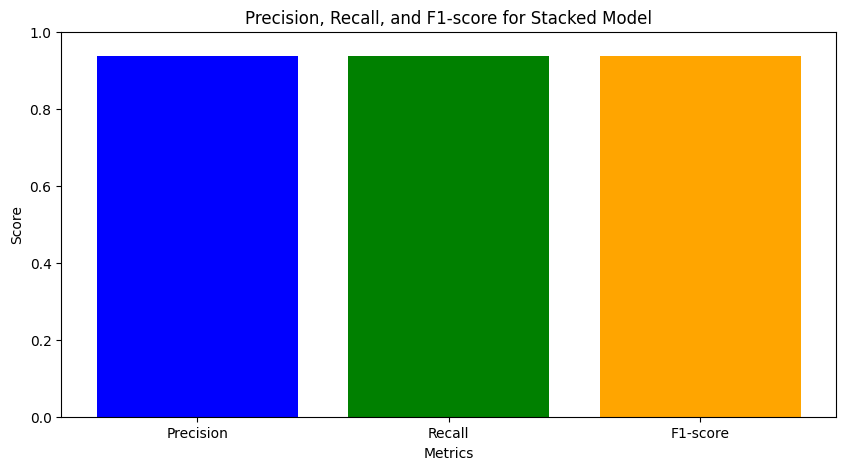

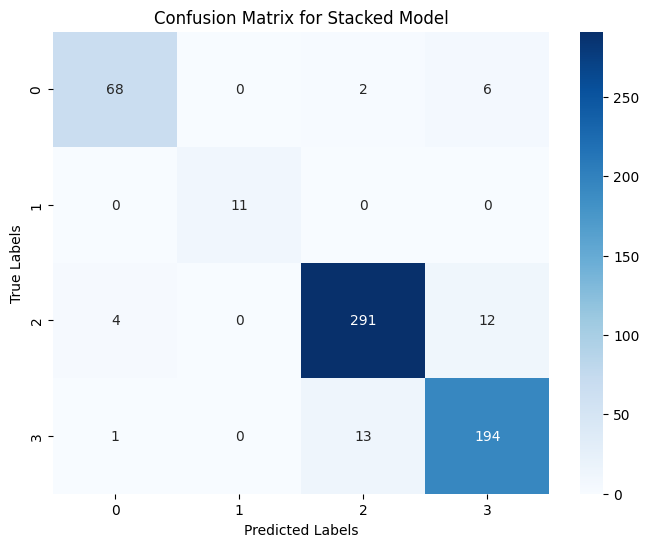

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Precision, Recall, and F1-score
scores = [precision_stacked, recall_stacked, f1_stacked]
score_names = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(10, 5))
plt.bar(score_names, scores, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1-score for Stacked Model')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_stacked, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Stacked Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
TN = confusion_mat_stacked[0, 0]
FN = confusion_mat_stacked[1, 0] + confusion_mat_stacked[2, 0]  # Adding FN from classes 1 and 2
NPV = TN / (TN + FN)
print("Negative Predictive Value (NPV):", NPV)


Negative Predictive Value (NPV): 0.9444444444444444


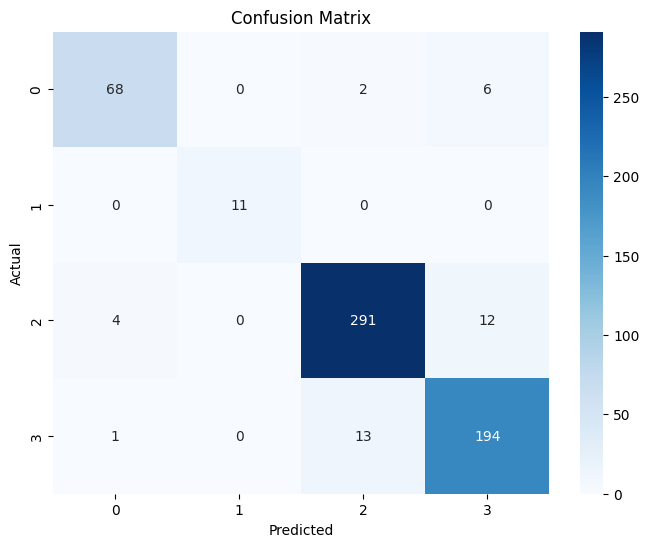

True Negatives (TN): 68
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 11


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels and rf_stacked.predict(X_test_stacked) contains the predicted labels
conf_mat = confusion_matrix(y_test, rf_stacked.predict(X_test_stacked))

# Calculate TN, FP, FN, TP
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print TN, FP, FN, TP
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)



In [ ]:
plt.figure(figsize=(10, 5))
